In [34]:
from dotenv import load_dotenv

In [35]:
load_dotenv()

True

In [36]:
from langchain_groq import ChatGroq

In [37]:
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [39]:
print(llm.invoke("What is the capital of France?").content)

<think>

</think>

The capital of France is Paris.


In [40]:

print(llm.invoke("What is the capital of india tell me in detail?").content)

<think>
Okay, so I need to figure out the capital of India and explain it in detail. Hmm, I remember that India is a big country with a rich history. I think the capital is Delhi, but I'm not entirely sure. Let me try to recall more details.

I've heard that Delhi is a very old city, maybe even ancient. It's in the north part of India, right? I think it's near the Yamuna River. Wait, wasn't there another city that used to be the capital before? Oh, right, I think it was Calcutta, but that was a long time ago when the British were ruling India. So after independence, they moved the capital to Delhi. That makes sense because Delhi has a lot of historical significance.

Now, about New Delhi. I remember that term being used a lot. Is New Delhi a part of Delhi? I think so. Maybe it's the area where the government buildings are. I've heard of the Rashtrapati Bhavan, which is the presidential palace, right? And there's the India Gate, which is a war memorial. So New Delhi is the administrativ

In [41]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [42]:
search_tool.invoke("What is the capital of France?")

[{'title': 'What is the Capital of France? - Mappr',
  'url': 'https://www.mappr.co/capital-cities/france/',
  'content': 'mappr logo\nmappr logo\n\nHome » Capital Cities » What is the Capital of France?\n\n# What is the Capital of France?\n\nParis is the capital of France. Also known as the “City of Light,” is not only the capital but also the most populous city of France. Paris is renowned globally for its art, fashion, gastronomy, and culture.\n\nA map showing France in yellow with surrounding countries in white, major cities marked, and Paris highlighted with a black dot. [...] However, Paris only became the official capital of France during the reign of Clovis I, in the late 5th and early 6th century. Before Clovis, the Merovingian kings did not rule from a fixed capital, but Clovis established his court in Paris, effectively making it the capital. Since then, with some interruptions, Paris has remained the capital of France. [...] The Palace of Versailles, a royal residence in th

In [43]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()
from typing import Annotated
from langchain_core.tools import tool

In [44]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with 'print(...)'. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"
    return result_str

In [45]:
python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

"Successfully executed:\n'''python\nx=10\ny=x+10\nprint(y)\n'''\nStdout: 20\n"

### WE HAVE TWO SUB AGENT
1. RESEARCHER- internet
2. CODER- executing the code

In [46]:
members=["researcher","coder"]

In [47]:
options = members+["FINISH"]

In [48]:
options

['researcher', 'coder', 'FINISH']

In [49]:
from typing import Literal
from typing_extensions import TypedDict

In [50]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [51]:
from langgraph.graph import MessagesState,StateGraph,START, END

In [52]:
class State(MessagesState):
    next:str

This is how the stage will look like

state={"messages": ["hi"], "next": "research_agent"}

In [53]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [66]:
system_prompt = f"""
You are a supervisor managing a task delegation system with the following workers: {members}.

Your job is to decide which worker should act next based on the user’s input.

Guidelines:
- Carefully read the user’s message.
- If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
- If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
- Do **not** invent tasks or assign actions unless the message clearly demands it.

Each worker will return results after completing their task.
Once all necessary tasks are completed, end the flow by responding with `FINISH`.

Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
"""

In [67]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [68]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my response {'next': 'researcher'}
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
    
    # class State(MessagesState):
    #   next:str
    # output of the state: state={"messages": ["hi"], "next": "researcher"}
    
    return Command(goto=goto, update={"next":goto})

In [69]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [70]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

### Orchestration

In [71]:
graph=StateGraph(State)

In [72]:
graph.add_node("supervisor", supervisor_agent)

In [73]:
graph.add_node("researcher", research_agent)

In [74]:
graph.add_node("coder", coder_agent)

In [75]:
graph.add_edge(START, "supervisor")

In [76]:
app=graph.compile()

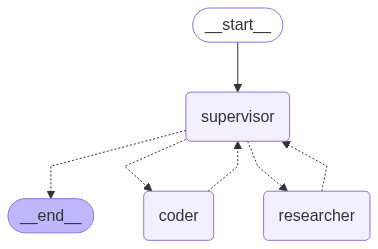

In [77]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [79]:
for s in app.stream({"messages": [("user", "Write a code to generate square of a given number.")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
(('coder:a9b58fdc-d511-bed3-2656-5b6fb243b09c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n07fsg3cp', 'function': {'arguments': '{"code":"def square(number):\\n    return number * number\\nprint(square(5))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 342, 'prompt_tokens': 190, 'total_tokens': 532, 'completion_time': 1.439867389, 'prompt_time': 0.011742525, 'queue_time': 0.202706434, 'total_time': 1.451609914}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7224028d-0a13-46b5-81ad-deb1f046919d-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'def square(number):\n    return number * number\nprint(square(5))'}, 'id': 'n07fsg3cp', 'type':